In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal

In [154]:
DATA_PATH = '../data/auto_mpg_transformed.csv'
SAVED_DATA_PATH = '../data/auto_mpg_inputed.csv'

In [155]:
df = pd.read_csv(DATA_PATH)

In [156]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,manufacturer,model
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA,chevrolet,chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA,buick,skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA,plymouth,satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA,amc,rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA,ford,torino


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   manufacturer  398 non-null    object 
 9   model         396 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 31.2+ KB


The feature horsepower has null values, I'll find a way to fill then later in this code.

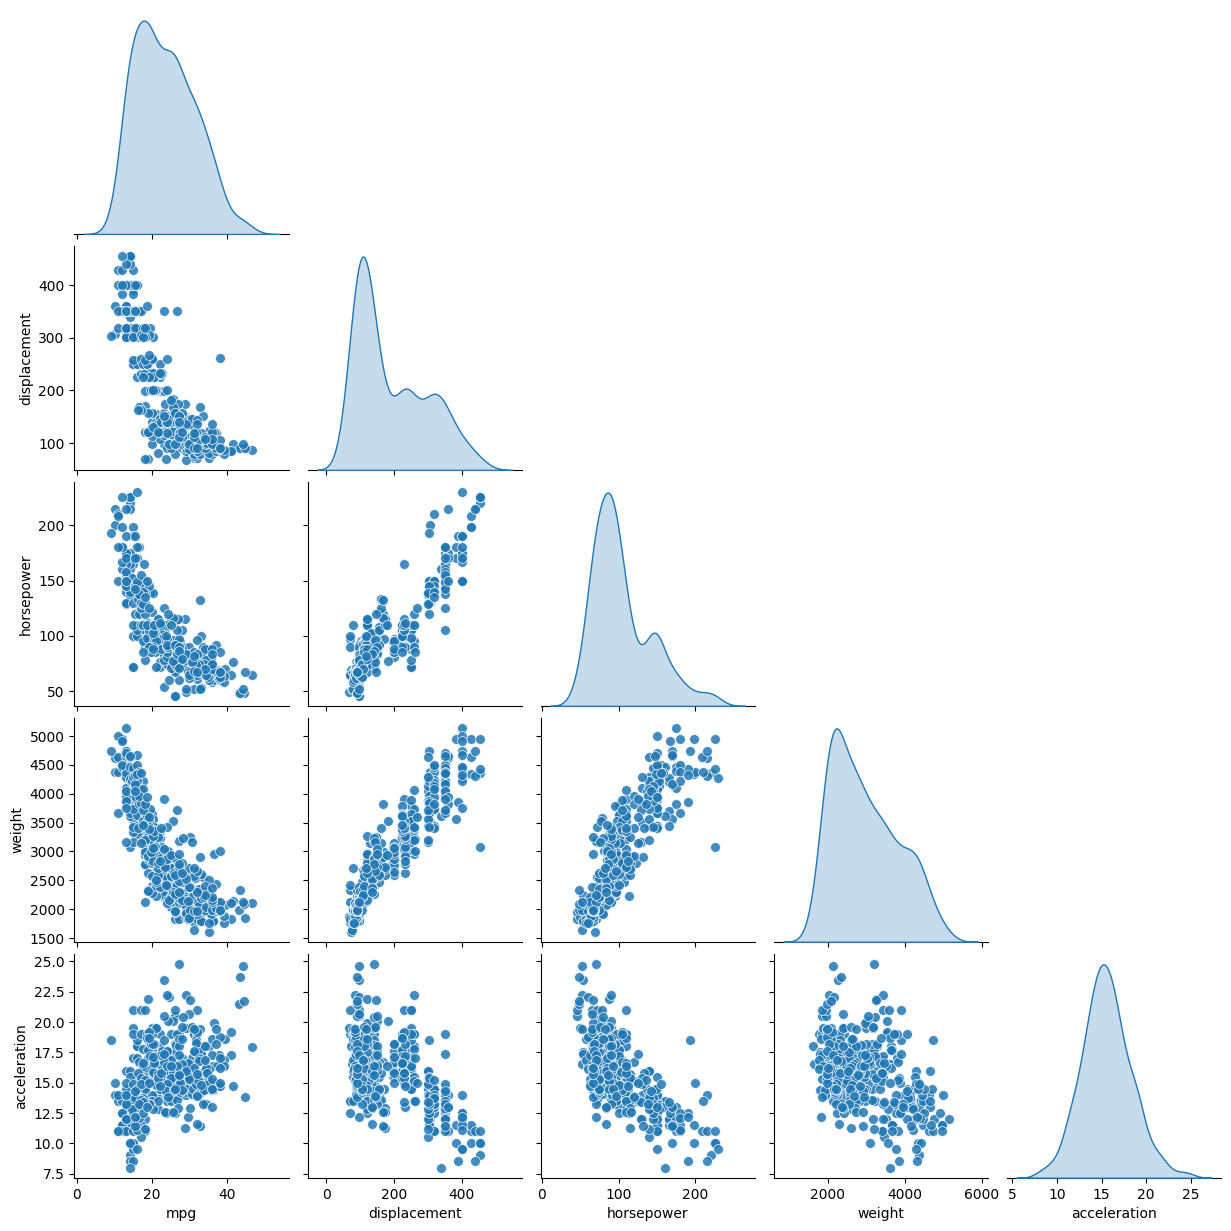

In [158]:
cols_to_not_pairplot = ['cylinders', 'model year', 'origin']
cols_to_pairplot = [col for col in df.select_dtypes('number').columns if col not in cols_to_not_pairplot]

sns.pairplot(
    df, 
    diag_kind='kde', 
    vars=cols_to_pairplot,
    corner=True,
    plot_kws={'s': 50, 'alpha': 0.85}
);

Relationships found between features numerical features and mpg:

- lighter car -> higher mpg

- less horsepower -> higher mpg

- smaller displacement -> higher mpg

- acceleration doesn't seem to have a strong relation with mpg as other features

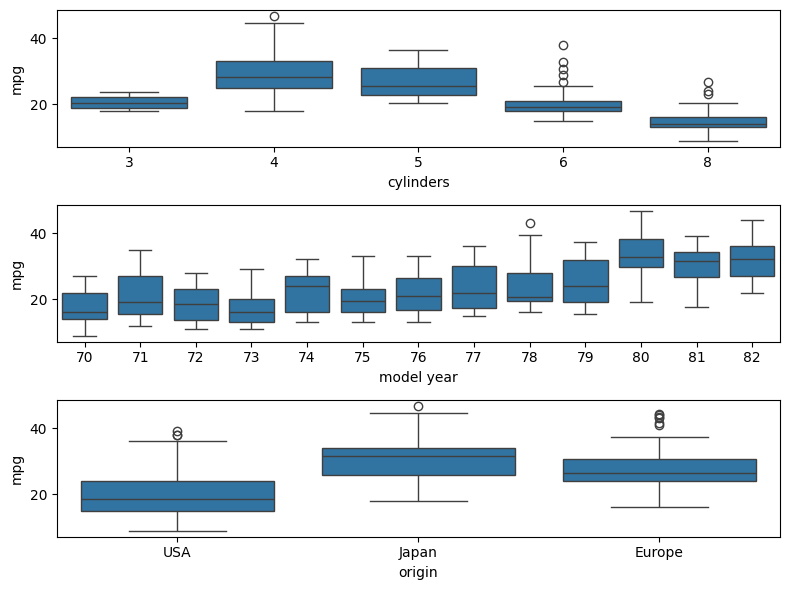

In [159]:
cols_to_boxplot = cols_to_not_pairplot
n_features = len(cols_to_boxplot)
fig, axs = plt.subplots(nrows=n_features, tight_layout=True, figsize=(8,2*n_features))

for col, ax in zip(cols_to_boxplot, axs):
    sns.boxplot(df, x=col, y='mpg', ax=ax)

plt.show()

Relationship between categorical features and mpg:

- 4 and 5 cylinders apparently have higher mpg

- through the years, cars presented higher mpg

- mpg is higher for Japan cars and smaller for USA cars

Deciding how to fill null values in the horsepower feature below

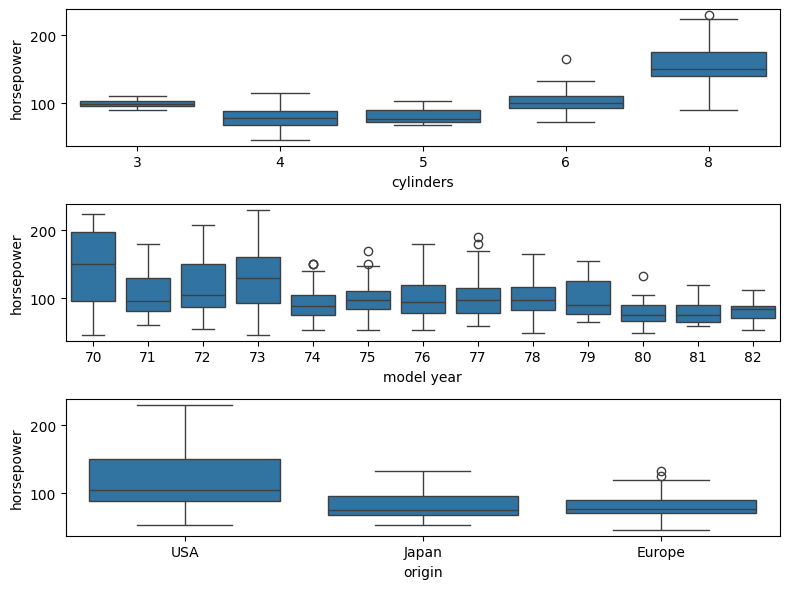

In [160]:
fig, axs = plt.subplots(nrows=n_features, tight_layout=True, figsize=(8,2*n_features))

for col, ax in zip(cols_to_boxplot, axs):
    sns.boxplot(df, x=col, y='horsepower', ax=ax)

Those 3 categorical features have a certain level of relationship with the horsepower, I can use a statistical test to confirm it and decide by which feature has stronger relationship with horsepower

In [161]:
stat_tests = {}
for col in cols_to_boxplot:
    groups = {}
    for name, group in df.groupby(col)['horsepower']:
        groups[name] = group.values
    statistic, p_value = kruskal(*groups.values(), nan_policy='omit')
    stat_tests[col] = (statistic, p_value)

sorted(stat_tests.items(), key=lambda x: x[1][1])

[('cylinders', (277.7425950554161, 6.834242622684356e-59)),
 ('origin', (105.59475799843663, 1.1759521262123952e-23)),
 ('model year', (84.7296275822132, 5.129986455852188e-13))]

After applying the Kruskal-Wallis test, we can see the cylinder feature to have the most different horsepower between categories, followed by origin and model year. Because of that I select to fill the horsepower with the median of the grouped data by cylinder and origin.

In [162]:
nan_idx_horsepower = df[df['horsepower'].isna()].index.tolist()
df[df['horsepower'].isna()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,manufacturer,model
32,25.0,4,98.0,NaN,2046.0,19.0,71,USA,ford,pinto
126,21.0,6,200.0,NaN,2875.0,17.0,74,USA,ford,maverick
330,40.9,4,85.0,NaN,1835.0,17.3,80,Europe,renault,lecar deluxe
336,23.6,4,140.0,NaN,2905.0,14.3,80,USA,ford,mustang cobra
354,34.5,4,100.0,NaN,2320.0,15.8,81,Europe,renault,18i
374,23.0,4,151.0,NaN,3035.0,20.5,82,USA,amc,concord dl


In [163]:
display(df.groupby(['cylinders', 'origin'])['horsepower'].median())

df['horsepower'] = df['horsepower'].fillna(df.groupby(['cylinders', 'origin'])['horsepower'].transform('median'))

df.loc[nan_idx_horsepower,:]

cylinders  origin
3          Japan      98.5
4          Europe     76.0
           Japan      70.0
           USA        84.0
5          Europe     77.0
6          Europe    122.5
           Japan     118.0
           USA       100.0
8          USA       150.0
Name: horsepower, dtype: float64

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,manufacturer,model
32,25.0,4,98.0,84.0,2046.0,19.0,71,USA,ford,pinto
126,21.0,6,200.0,100.0,2875.0,17.0,74,USA,ford,maverick
330,40.9,4,85.0,76.0,1835.0,17.3,80,Europe,renault,lecar deluxe
336,23.6,4,140.0,84.0,2905.0,14.3,80,USA,ford,mustang cobra
354,34.5,4,100.0,76.0,2320.0,15.8,81,Europe,renault,18i
374,23.0,4,151.0,84.0,3035.0,20.5,82,USA,amc,concord dl


In [164]:
df.to_csv(SAVED_DATA_PATH, index=False)